# 6.时序差分算法
在强化学习中，**模型**通常指与智能体交互的**环境模型**，即对**环境的状态转移概率和奖励函数**进行建模
根据是否具有**环境模型**，强化学习算法分为两种：
- 基于模型的强化学习（model-based reinforcement learning）
- 无模型的强化学习（model-free reinforcement learning）

**第5节的动态规划算法** 就类似于**有监督学习**任务，直接显式的给出了数据的分布公式，智能体其实并不需要和环境真正交互来采样数据，所以为**基于模型的强化学习**

但对于大部分强化学习现实场景（例如电子游戏或者一些复杂物理环境），其马尔可夫决策过程的**状态转移概率**是 无法写出来的
在这种情况下，智能体只能和环境进行交互，通过交互收集**信息**，这类学习方法统称为**无模型的强化学习（model-free reinforcement learning）**

本节讲解**无模型的强化学习**中的两大经典算法：
- Sarsa
- Q-learning

它们都是基于时序差分（temporal difference，TD）的强化学习算法

导入相关库

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # tqdm是显示循环进度条的库

## 6.1 时序差分方法
**时序差分** 是一种用来 **估计** 一个 **策略的价值函数** 的方法
结合了**蒙特卡洛+动态规划算法**的思想:
- 可以从样本数据中学习，不需要事先知道环境
- 根据贝尔曼方程的思想，利用后续状态的价值估计来更新当前状态的价值估计

有
$$\begin{aligned}
V_{\pi}(s) & =\mathbb{E}_\pi[G_t|S_t=s] \\
 & =\mathbb{E}_\pi[\sum_{k=0}^\infty\gamma^kR_{t+k}|S_t=s] \\
 & =\mathbb{E}_\pi[R_t+\gamma\sum_{k=0}^\infty\gamma^kR_{t+k+1}|S_t=s] \\
 & =\mathbb{E}_\pi[R_t+\gamma V_\pi(S_{t+1})|S_t=s]
\end{aligned}$$

- **蒙特卡洛方法**：将上式第一行作为更新的目标（等整个序列结束之后才能计算得到这一次的回报）
- **时序差分方法**：将上式最后一行作为更新的目标（每采样一步就可以更新状态价值估计）

最终**时序差分方法**用**当前获得的奖励** + **下一个状态的价值估计**,来作为在当前状态估计的回报:
$$V(s_t)\leftarrow V(s_t)+\alpha[r_t+\gamma V(s_{t+1})-V(s_t)]$$


### 超参数解释:
$\alpha$ : 学习率，控制每次更新时新信息对旧信息的影响程度
$\gamma$ : 折扣因子，控制未来奖励对当前决策的影响
通常都在 [0,1] 之间
其中$r_t+\gamma V(s_{t+1})-V(s_t)$被称为**时序差分（temporal difference，TD）误差（error）**

## 6.2 Sarsa 算法
类似**策略迭代**：策略评估 + 策略提升
- 用**时序差分方法**来估计价值函数(策略评估)
- 用贪婪算法来选取在某个状态下动作价值最大的那个动作$\arg\max_{a}Q(s,a)$(策略提升)

所以直接用**时序差分算法**来估计**动作价值函数Q**:
$$Q(s_t,a_t)\leftarrow Q(s_t,a_t)+\alpha[r_t+\gamma Q(s_{t+1},a_{t+1})-Q(s_t,a_t)]$$

### 问题:
1. 如果用时序差分算法估计策略的状态价值函数，需要用极大量的样本来进行更新吗？
- 实际上可以直接用一些样本来评估策略，然后就直接策略提升。因为策略提升可以在策略评估未完全进行的情况进行，回顾一下，**价值迭代**就是这样，这其实就是 **广义策略迭代（generalized policy iteration）** 的思想。
2. 贪婪情况下，会导致某些状态动作对永远无法被评估，以至于无法对其动作价值进行估计，进而无法保证策略提升后的策略比之前的好.
- 采用$\epsilon$-贪婪策略。

### 悬崖漫步环境 :
仍然在悬崖漫步环境下学习体验算法，只不过此时环境不需要提供奖励函数和状态转移函数，而需要提供一个和智能体进行交互的函数step()

In [49]:
class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0  # 记录当前智能体位置的横坐标
        self.y = self.nrow - 1  # 记录当前智能体位置的纵坐标

    def step(self, action):  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):  # 回归初始状态,坐标轴原点在左上角
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

### Sarsa 算法：
主要维护一个表格Q_table()，用来储存当前策略下所有状态动作对的价值

In [50]:
class Sarsa:
    """ Sarsa算法 """
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数

    def take_action(self, state):  # 选取下一步的操作,具体实现为epsilon-贪婪
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def best_action(self, state):  # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):  # 若两个动作的价值一样,都会记录下来
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1, a1):
        td_error = r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 3310.00it/s, episode=500, return=-18.900]


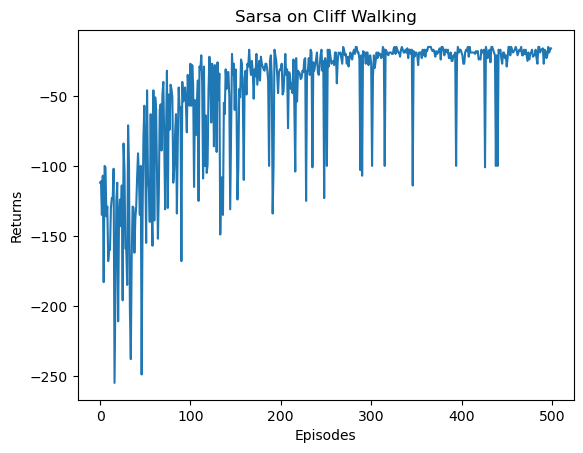

In [51]:
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = Sarsa(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    # tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()

可以看到随着训练的进行，Sarsa 算法获得的回报越来越高。在进行 500 条序列的学习后，可以获得 −20 左右的回报，此时已经非常接近最优策略
看一下 Sarsa 算法得到的策略在各个状态下会使智能体采取什么样的动作：

In [52]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print('****', end=' ')
            elif (i * env.ncol + j) in end:
                print('EEEE', end=' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()


In [53]:
action_meaning = ['^', 'v', '<', '>']
print('Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

Sarsa算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ooo> ^ooo ooo> ooo> ooo> ooo> ^ooo ^ooo ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 
